## **Streaming**

In [3]:
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv, find_dotenv
from langchain_openai import ChatOpenAI

_ = load_dotenv(find_dotenv())
chat = ChatOpenAI(model = 'gpt-3.5-turbo', temperature = 0)

from typing import TypedDict
from typing_extensions import Annotated
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph.message import add_messages
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image

### **Streaming**
We use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x. 

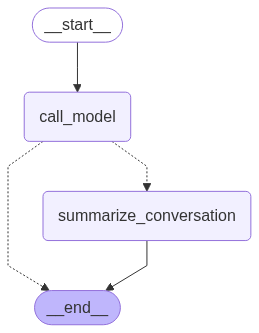

In [ ]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    summary: str


def call_model(state: State, config: RunnableConfig):
    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content = system_message)] + state["messages"]
    else:
        messages = state["messages"]
    
    # Without this LangChain assumes stream = False
    response = chat.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    summary = state.get("summary", "")
    
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content = summary_message)]
    response = chat.invoke(messages)
    
    delete_messages = [RemoveMessage(id = m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

def should_continue(state: State):
    messages = state["messages"]
    
    if len(messages) > 6:
        return "summarize_conversation"
    return END


builder = StateGraph(State)
builder.add_node(call_model)
builder.add_node(summarize_conversation)

builder.set_entry_point("call_model")
builder.add_conditional_edges(
    "call_model", 
    should_continue, {
        END: END,
        "summarize_conversation": "summarize_conversation"
})
builder.add_edge("summarize_conversation", END)


memory = MemorySaver()
graph = builder.compile(checkpointer = memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### **Streaming full state**
`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

In [5]:
config = {"configurable": {"thread_id": "1"}}

for chunk in graph.stream({"messages": [HumanMessage(content = "Hi! I'm Khoa")]}, config, stream_mode = "updates"):
    print(chunk)

{'call_model': {'messages': AIMessage(content='Nice to meet you, Khoa! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 13, 'total_tokens': 28, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BpS6fFsuaF1he0xdrLTM5QE8x1OOJ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--56de334e-29b2-4f8c-acb4-7b04e49c0967-0', usage_metadata={'input_tokens': 13, 'output_tokens': 15, 'total_tokens': 28, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [ ]:
config = {"configurable": {"thread_id": "2"}}

for event in graph.stream({"messages": [HumanMessage(content = "Hi! I'm Khoa")]}, config, stream_mode = "values"):
    for m in event['messages']:
        print (m)

content="Hi! I'm Khoa" additional_kwargs={} response_metadata={} id='abbbfab6-5da6-458e-a939-fefe9ef4cee9'
content="Hi! I'm Khoa" additional_kwargs={} response_metadata={} id='abbbfab6-5da6-458e-a939-fefe9ef4cee9'
content='Nice to meet you, Khoa! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 13, 'total_tokens': 28, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BpS9jKjAMZqUPYgwZQ83LWJJXkpIG', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--2bf45d05-57c4-4b5e-95b4-8813c3b99f6e-0' usage_metadata={'input_tokens': 13, 'output_tokens': 15, 'total_tokens': 28, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_detai

### Streaming tokens
We can view streaming tokens live as they are generated via the [`.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node)

Each event is a dict with a few keys:
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

In [17]:
config = {"configurable": {"thread_id": "3"}}

async for event in graph.astream_events({"messages": [HumanMessage(content = "Tell me about Squid Game 3")]}, config, version = "v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: call_model. Type: on_chain_start. Name: call_model
Node: call_model. Type: on_chat_model_start. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [ ]:
streaming_node = 'call_model'
config = {"configurable": {"thread_id": "4"}}

async for event in graph.astream_events({"messages": [HumanMessage(content = "Tell me about Squid Game 3")]}, config, version = "v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == streaming_node:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--4ef6f282-9b81-460f-87ac-4b097e2cf9fd')}
{'chunk': AIMessageChunk(content='I', additional_kwargs={}, response_metadata={}, id='run--4ef6f282-9b81-460f-87ac-4b097e2cf9fd')}
{'chunk': AIMessageChunk(content=' apologize', additional_kwargs={}, response_metadata={}, id='run--4ef6f282-9b81-460f-87ac-4b097e2cf9fd')}
{'chunk': AIMessageChunk(content=' for', additional_kwargs={}, response_metadata={}, id='run--4ef6f282-9b81-460f-87ac-4b097e2cf9fd')}
{'chunk': AIMessageChunk(content=' the', additional_kwargs={}, response_metadata={}, id='run--4ef6f282-9b81-460f-87ac-4b097e2cf9fd')}
{'chunk': AIMessageChunk(content=' confusion', additional_kwargs={}, response_metadata={}, id='run--4ef6f282-9b81-460f-87ac-4b097e2cf9fd')}
{'chunk': AIMessageChunk(content=' in', additional_kwargs={}, response_metadata={}, id='run--4ef6f282-9b81-460f-87ac-4b097e2cf9fd')}
{'chunk': AIMessageChunk(content=' my', additional_kwargs=

In [22]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph.astream_events({"messages": [HumanMessage(content = "Tell me about Squid Game 3")]}, config, version = "v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end = " - ")

 - I - 'm -  sorry -  for -  the -  confusion -  in -  my -  previous -  response - . -  As -  of -  now - , -  there -  is -  no -  official -  information -  or -  confirmation -  about -  a -  third -  season -  of -  Squ - id -  Game - . -  The -  show - 's -  creator - , -  H - wang -  Dong - -h - y - uk - , -  has -  not -  announced -  any -  plans -  for -  a -  third -  season - , -  and -  Netflix -  has -  not -  confirmed -  the -  renewal -  of -  the -  series - .

 - The -  first -  season -  of -  Squ - id -  Game -  was -  a -  massive -  success - , -  becoming -  one -  of -  the -  most - -w - atched -  shows -  on -  Netflix -  and -  gaining -  a -  huge -  international -  following - . -  Given -  the -  popularity -  of -  the -  show - , -  it -  is -  possible -  that -  Netflix -  may -  consider -  renew - ing -  it -  for -  a -  third -  season -  in -  the -  future - . -  However - , -  at -  this -  time - , -  there -  is -  no -  concrete -  informat

## **Breakpoints**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from typing import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import  MemorySaver
from IPython.display import display, Image

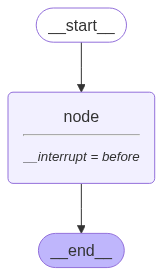

In [49]:
class State(TypedDict):
    messages: str


def node(state):
    return {'messages': state['messages'] + ' am testing breakpoint.'}


builder = StateGraph(State)
builder.add_node(node)

builder.set_entry_point("node")
builder.add_edge("node", END)


memory = MemorySaver()
graph = builder.compile(interrupt_before = ["node"], checkpointer = memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
config = {"configurable": {"thread_id": "1"}}
for event in graph.stream({"messages": "I"}, config, stream_mode = "values"):
    print (event)

{'messages': 'I'}


In [45]:
graph.get_state(config)

StateSnapshot(values={'messages': 'I'}, next=('node',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f058a4b-9952-689f-8002-125f894f52be'}}, metadata={'source': 'loop', 'writes': None, 'step': 2, 'parents': {}, 'thread_id': '1'}, created_at='2025-07-04T07:01:35.991799+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f058a4b-994e-616d-8001-9bb5d8be4f91'}}, tasks=(PregelTask(id='15c3c7ca-b0fb-3b75-dc48-00ff900ef848', name='node', path=('__pregel_pull', 'node'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [50]:
graph.update_state(
    config,
    {"messages": "Oh, I just update it!. I"}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f058a67-9da8-6c9d-8000-fe559ff074b9'}}

In [51]:
for event in graph.stream(None, config, stream_mode = "values"):
    print (event)

{'messages': 'Oh, I just update it!. I'}
{'messages': 'Oh, I just update it!. I am testing breakpoint.'}


## **Dynamic breakpoints**

In [57]:
import warnings
warnings.filterwarnings("ignore")

from typing import TypedDict
from langgraph.errors import NodeInterrupt
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import  MemorySaver
from IPython.display import display, Image

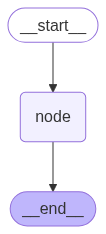

In [70]:
class State(TypedDict):
    messages: str


def node(state):
    if (len(state["messages"]) > 1):
        raise NodeInterrupt(f"Received messages that has more than 1 character: {state['messages']}")
    return {'messages': state['messages'] + ' am testing dynamic breakpoint.'}


builder = StateGraph(State)
builder.add_node(node)

builder.set_entry_point("node")
builder.add_edge("node", END)


memory = MemorySaver()
graph = builder.compile(checkpointer = memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [71]:
config = {"configurable": {"thread_id": "1"}}
for event in graph.stream({'messages': "Hello my future me. I.."}, config, stream_mode = "values"):
    print (event)

{'messages': 'Hello my future me. I..'}
{'__interrupt__': (Interrupt(value='Received messages that has more than 1 character: Hello my future me. I..', resumable=False, ns=None),)}


In [72]:
print(graph.get_state(config), '\n' * 2)
graph.update_state(
    config,
    {"messages": "I.."}
)

config = {"configurable": {"thread_id": "1"}}
for event in graph.stream(None, config, stream_mode = "values"):
    print (event)

StateSnapshot(values={'messages': 'Hello my future me. I..'}, next=('node',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f058a8a-6d76-6cfa-8000-d8d8c7671838'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-07-04T07:29:42.537138+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f058a8a-6d74-65f1-bfff-f40218220c89'}}, tasks=(PregelTask(id='f5792a81-d6fb-9a38-3a30-969c47f61acf', name='node', path=('__pregel_pull', 'node'), error=None, interrupts=(Interrupt(value='Received messages that has more than 1 character: Hello my future me. I..', resumable=False, ns=None),), state=None, result=None),), interrupts=(Interrupt(value='Received messages that has more than 1 character: Hello my future me. I..', resumable=False, ns=None),)) 


{'messages': 'I..'}
{'__interrupt__': (Interrupt(value='Received messages that has more than 1 character: I..', resu

In [73]:
print(graph.get_state(config).next, '\n' * 2)
graph.update_state(
    config,
    {"messages": "I"}
)

config = {"configurable": {"thread_id": "1"}}
for event in graph.stream(None, config, stream_mode = "values"):
    print (event)

('node',) 


{'messages': 'I'}
{'messages': 'I am testing dynamic breakpoint.'}


## **Time travel**

In [97]:
import warnings
warnings.filterwarnings("ignore")

from typing import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import  MemorySaver
from IPython.display import display, Image

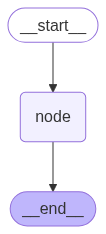

In [98]:
class State(TypedDict):
    messages: str


def node(state):
    return {'messages': state['messages'] + ' am testing dynamic timetravel.'}


builder = StateGraph(State)
builder.add_node(node)

builder.set_entry_point("node")
builder.add_edge("node", END)


memory = MemorySaver()
graph = builder.compile(checkpointer = memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [99]:
config = {"configurable": {"thread_id": "1"}}
for event in graph.stream({"messages": "I.."}, config, stream_mode = "values"):
    print (event)

{'messages': 'I..'}
{'messages': 'I.. am testing dynamic timetravel.'}


In [100]:
graph.get_state(config)

StateSnapshot(values={'messages': 'I.. am testing dynamic timetravel.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f058acd-2950-6ecd-8001-270e975982b9'}}, metadata={'source': 'loop', 'writes': {'node': {'messages': 'I.. am testing dynamic timetravel.'}}, 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-07-04T07:59:33.908858+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f058acd-294c-60bf-8000-87c28dcd1c04'}}, tasks=(), interrupts=())

### **Brownsing History**

In [101]:
allState = [s for s in graph.get_state_history(config)]
len(allState)

3

### **Replaying**
![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

In [102]:
to_replay = allState[-2]
to_replay

StateSnapshot(values={'messages': 'I..'}, next=('node',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f058acd-294c-60bf-8000-87c28dcd1c04'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-07-04T07:59:33.906860+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f058acd-2949-69a2-bfff-e02f6a585b85'}}, tasks=(PregelTask(id='b4984048-5660-22ad-986c-cf6e033e92bd', name='node', path=('__pregel_pull', 'node'), error=None, interrupts=(), state=None, result={'messages': 'I.. am testing dynamic timetravel.'}),), interrupts=())

In [103]:
for event in graph.stream(None, to_replay.config, stream_mode = "values"):
    print (event)

{'messages': 'I..'}
{'messages': 'I.. am testing dynamic timetravel.'}


### **Forking**
Forking is to run from that same step, but with a different input.

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [104]:
to_fork = allState[-2]
fork_config = graph.update_state(
    to_fork.config,
    {"messages": 'Hello my future me. I..'},
)

# In case of AnyMessage:
# [HumanMessage(content = 'Hello my future me. I..',
#               id = to_fork.values["messages"][0].id)]

In [105]:
allState = [s for s in graph.get_state_history(config) ]
allState[0]

StateSnapshot(values={'messages': 'Hello my future me. I..'}, next=('node',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f058acd-2aeb-6996-8001-18501e05cf24'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': 'Hello my future me. I..'}}, 'step': 1, 'parents': {}, 'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f058acd-294c-60bf-8000-87c28dcd1c04'}, created_at='2025-07-04T07:59:34.077071+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f058acd-294c-60bf-8000-87c28dcd1c04'}}, tasks=(PregelTask(id='f0302460-b8db-9c0d-7a0a-cb885c300e66', name='node', path=('__pregel_pull', 'node'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [ ]:
graph.get_state(config) # is reset

StateSnapshot(values={'messages': 'Hello my future me. I..'}, next=('node',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f058acd-2aeb-6996-8001-18501e05cf24'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': 'Hello my future me. I..'}}, 'step': 1, 'parents': {}, 'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f058acd-294c-60bf-8000-87c28dcd1c04'}, created_at='2025-07-04T07:59:34.077071+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f058acd-294c-60bf-8000-87c28dcd1c04'}}, tasks=(PregelTask(id='f0302460-b8db-9c0d-7a0a-cb885c300e66', name='node', path=('__pregel_pull', 'node'), error=None, interrupts=(), state=None, result=None),), interrupts=())